In [272]:
import math
import random
from sympy import sympify, simplify
from typing import List, Dict

class Node:
    def __init__(self, value, node_type):
        self.value = value
        self.left = None
        self.right = None
        self.type = node_type

class Member:
    def __init__(self, variables: List[str], maximum_depth = 7, root = None):
        self.maximum_depth = maximum_depth
        self.variables = variables
        if root is None: self.root = self.create_random_tree()
        else: self.root = root
        self.age = 1
        self.fitness = 0
    def __call__(self, variable_values):
        return self._evaluate_tree(self.root, {variable:value for variable,value in zip(self.variables,variable_values)})
    
    def _evaluate_tree(self, root: Node, variable_values: Dict[str, float]) -> float:
        if root is None:
            return None
        if root.type == "Constant":
            return root.value
        elif root.type == "Variable":
            return variable_values[root.value]
        else:
            left_subtree_value = self._evaluate_tree(root.left, variable_values)
            right_subtree_value = self._evaluate_tree(root.right, variable_values)
            if left_subtree_value == "Undefined" or right_subtree_value == "Undefined":
                return "Undefined"
            try:
                if root.value == "sin":
                    return math.sin(left_subtree_value)
                elif root.value == "cos":
                    return math.cos(left_subtree_value)
                elif root.value == "+":
                    return left_subtree_value + right_subtree_value
                elif root.value == "-":
                    return left_subtree_value - right_subtree_value
                elif root.value == "*":
                    return left_subtree_value * right_subtree_value
                elif root.value == "^":
                    return_val = (left_subtree_value) ** right_subtree_value
                    if isinstance(return_val,complex):
                        return "Undefined"
                    else:
                        return return_val
                elif root.value == "/":
                    if right_subtree_value == 0:
                        return "Undefined"
                    return left_subtree_value / right_subtree_value
            except Exception:
                return "Undefined"

    def print_tree(self) -> str:
        return self._print_tree(self.root)

    def _print_tree(self, root: Node) -> str:
        if root is None:
            return None
        if root.type == "Constant":
            return str(root.value)
        elif root.type == "Variable":
            return root.value
        else:
            left_subtree_value = self._print_tree(root.left)
            right_subtree_value = self._print_tree(root.right)
            if root.value == "sin":
                return f"sin({left_subtree_value})"
            elif root.value == "cos":
                return f"cos({left_subtree_value})"
            elif root.value == "+":
                return f"({left_subtree_value} + {right_subtree_value})"
            elif root.value == "^":
                return f"({left_subtree_value}) ^ ({right_subtree_value})"
            elif root.value == "-":
                return f"({left_subtree_value} - {right_subtree_value})"
            elif root.value == "*":
                return f"({left_subtree_value} * {right_subtree_value})"
            elif root.value == "/":
                return f"({left_subtree_value} / {right_subtree_value})"

    def print_simplified_tree(self) -> str:
        try:
            return simplify(sympify(self.print_tree()))
        except Exception:
            return "Simplification Failed ->" + self.print_tree()
    
    def create_random_tree(self, current_depth = 0) -> Node:
        step_size = 0.4/self.maximum_depth #this is how much the probability of a leaf node increases - a fraction of 30% 
        leaf_probability = current_depth*step_size
        if current_depth >= self.maximum_depth or random.random() < leaf_probability:
            if random.random() < 0.3:
                return Node(random.choice(self.variables), 'Variable')
            else:
                return Node(random.uniform(-10, 10), 'Constant')
        else:
            operator = random.choice(['+', '-', '*', '/', '^', 'cos', 'sin'])
            op_node = Node(operator, "Operator")
            if operator in {'+', '-', '*', '/', '^'}:
                left_subtree = self.create_random_tree(current_depth + 1)
                right_subtree = self.create_random_tree(current_depth + 1)
                op_node.left = left_subtree
                op_node.right = right_subtree
            else:
                left_subtree = self.create_random_tree(current_depth + 1)
                op_node.left = left_subtree
            return op_node

    def random_walk(self, length: int) -> Node:
        return self._random_walk(self.root, length)

    def _random_walk(self, tree_root: Node, length: int) -> Node:
        steps = 0
        ptr = tree_root
        while steps < length:
            if ptr.left is None and ptr.right is None:
                return ptr
            if ptr.left is None:
                ptr = ptr.right
                steps += 1
            elif ptr.right is None:
                ptr = ptr.left
                steps += 1
            else:
                if random.random() < 0.5:
                    ptr = ptr.left
                else:
                    ptr = ptr.right
                steps += 1
        return ptr

    def mutate(self):
        self._mutate(self.root)

    def _mutate(self, root: Node):
        random_node = self.random_walk(random.uniform(0, self.current_depth()))
        if random_node.type == "Operator":
            random_node.value = random.choice(['+', '-', '*', '/', '^', 'cos', 'sin'])
        else:
            random_node.type = random.choice(["Variable", "Constant"])
            if random_node.type == "Constant":
                random_node.value = random.uniform(-10, 10)
            else:
                random_node.value = random.choice(self.variables)
    def current_depth(self) -> int:
        return self._current_depth(self.root)

    def _current_depth(self, root: Node) -> int:
        if root is None:
            return 0
        return max(self._current_depth(root.left), self._current_depth(root.right)) + 1


In [368]:
import copy 
import matplotlib.pyplot as plt
class Population:
    def __init__(self, inputs, outputs, variables, max_depth, size, criteria):
        self.inputs = inputs
        self.outputs = outputs
        self.size = size
        self.variables = variables
        self.max_depth = max_depth
        self.criteria = criteria
        # HERE COMES GENESIS
        self.population = [Member(self.variables, self.max_depth) for _ in range(size)]
        for m in self.population:
            m.fitness = self.Fitness(m, criteria)
        self.max_list = []


    def calc_reproduction_p(self):
        p = []
        cum_fitness = 0
        for member in self.population:
            f_m = member.fitness * (math.e**(-0.001*member.age))
            if math.isnan(f_m):
                p.append(0)
                continue
            elif f_m == float('inf'):
                return(f"A perfect specimen was found: {member.print_tree()}")
            else:
                p.append(f_m)
                cum_fitness += f_m
        #normalize again:
        for i in range(len(p)):
            p[i] = p[i]/cum_fitness
        return p
    
    def Fitness(self, member, criteria):
        residuals = 0
        for i in range(len(self.inputs[0])):
            if self.inputs.shape[0] == 1 or self.inputs.shape[0]>2:
                tree_value = member([self.inputs[0][i]])
            elif self.inputs.shape[0] == 2:
                tree_value = member([self.inputs[0][i], self.inputs[1][i]])
            if tree_value == 'Undefined' or math.isnan(tree_value):
                return 0
            residuals += (tree_value - self.outputs[0][i])**2
        if criteria == "rmse":
            if (rmse := math.sqrt(residuals/len(self.inputs))) == 0:
                return float('inf')
            else:
                v = 1 / rmse
                return v
        elif criteria == "R2":
            SS_res = residuals
            mean_outputs = np.mean(self.outputs)
            SS_total = sum([output/mean_outputs for output in self.outputs])
            r2 = 1 - SS_res/SS_total
            if r2 == float('inf') or r2 == float('-inf'):
                return -1000
            return 1 - SS_res/SS_total
    
    def Crossover(self, member1:Member, member2:Member) -> Member:
        #l1 : are we going to keep the left part of tree 1? if not we're going to keep the right part
        #l2 : are we going to keep the left part of tree 2? if not we're going to keep the right part
        root1, root2 = member1.root, member2.root
        if random.random()<0.5:
            new_root = Node(root1.value, root1.type)
        else:
            new_root = Node(root2.value, root2.type)
        if random.random()<0.5 or root1.right is None: #Select which part of root1 we want to keep
            l1 = True
        else:
            l1 = False
        if random.random()<0.5 or root2.right is None:
            l2 = True
        else:
            l2 = False
        if (l1 and l2):
            new_root.left = copy.deepcopy(root1.left)
            new_root.right = copy.deepcopy(root2.left)
        elif (not l1 and not l2):
            new_root.left = copy.deepcopy(root1.right)
            new_root.right = copy.deepcopy(root2.right)
        elif(l1):
            new_root.left = copy.deepcopy(root1.left)
            new_root.right = copy.deepcopy(root2.right)
        elif(l2):
            new_root.left = copy.deepcopy(root2.left)
            new_root.right = copy.deepcopy(root1.right)
        new_member = Member(member1.variables, member1.maximum_depth, new_root)
        return new_member
    
    def update_age(self):
        for member in self.population:
            member.age += 1
    
    def PlotLeader(self):
        leader = self.population[0]
        leader_y = []
        for input in self.inputs[0]:
            tree_value = leader([input])
            if tree_value == 'Undefined' or math.isnan(tree_value):
                leader_y.append(0)
            else:
                leader_y.append(tree_value)
        plt.plot(self.inputs.reshape(-1,1), self.outputs.reshape(-1,1), label = "Actual Function")
        plt.plot(self.inputs.reshape(-1,1), leader_y , label = "This Generation's Top Leader")
        plt.legend()
        plt.show()

    def Evolve(self):
        #the idea of age regularization was taken from this paper on PySR: https://arxiv.org/abs/2305.01582
        self.update_age()
        self.population.sort(key = lambda member: member.fitness, reverse = True)
        print("Leaders of the previous generation:(Simplified using Sympy) ")
        for m in self.population[:3]:
            print(m.print_simplified_tree(), "Fitness: ", m.fitness)
        print("\n")
        children = []
        p = self.calc_reproduction_p()
        if(isinstance(p, str)):
            print(p)
            return
        for _ in range(self.size):
            couple = np.random.choice(self.population, 2 , p = p , replace = False)
            child = self.Crossover(couple[0], couple[1])
            if(random.random() < 0.3):
                child.mutate()
            child.fitness = self.Fitness(child, self.criteria)
            children.append(child)
        children.sort(key = lambda member: member.fitness, reverse = True)
        new_population = copy.deepcopy(self.population[:self.size//2]) + copy.deepcopy(children[:len(children)//2])
        self.population = copy.deepcopy(new_population) 
            

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3244\1572688157.py:45: RuntimeWarning: overflow encountered in scalar power
  residuals += (tree_value - self.outputs[0][i])**2
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3244\504112048.py:48: RuntimeWarning: overflow encountered in scalar power
  return_val = (left_subtree_value) ** right_subtree_value
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3244\504112048.py:48: RuntimeWarning: invalid value encountered in scalar power
  return_val = (left_subtree_value) ** right_subtree_value
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3244\504112048.py:48: RuntimeWarning: divide by zero encountered in scalar power
  return_val = (left_subtree_value) ** right_subtree_value


Leaders of the previous generation:(Simplified using Sympy) 
2.815804835039114*x + 16.264685856258345 Fitness:  0.006971712351120386
2.737963517432374*x + 2.0404852573847337 Fitness:  0.0030734833350349595
3.9415859331191943*x Fitness:  0.002542815637927869




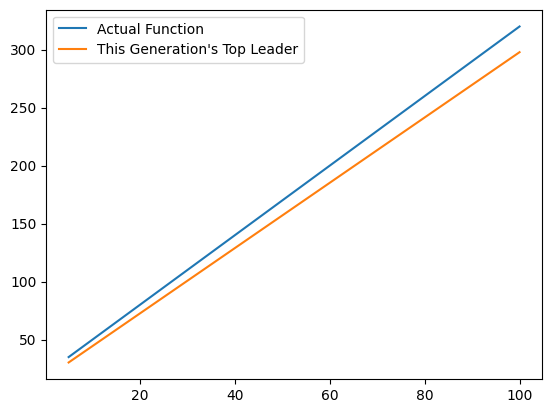

Leaders of the previous generation:(Simplified using Sympy) 
2.815804835039114*x + 23.65642091750264 Fitness:  0.012679766026446555
2.815804835039114*x + 19.228459133826018 Fitness:  0.008604622789067186
29.87632329941541**cos(x) + 2.815804835039114*x + 16.57761045675793 Fitness:  0.007888933905332123


Leaders of the previous generation:(Simplified using Sympy) 
2.815804835039114*x + 26.37983743833365 Fitness:  0.016471346039810195
2.815804835039114*x + 25.66319567556191 Fitness:  0.015414100546026136
2.815804835039114*x + 25.12672971876483 Fitness:  0.014637099366655502


Leaders of the previous generation:(Simplified using Sympy) 
3.0192075298096702*x + 16.57761045675793 Fitness:  0.040454216419124125
3.1536473227804989*x + 9.820163553645773 Fitness:  0.02104458986643009
3.1536473227804989*x + 14.228434364276174 Fitness:  0.02068123280804537


Leaders of the previous generation:(Simplified using Sympy) 
3.0192075298096702*x + 16.57761045675793 Fitness:  0.040454216419124125
3.019207

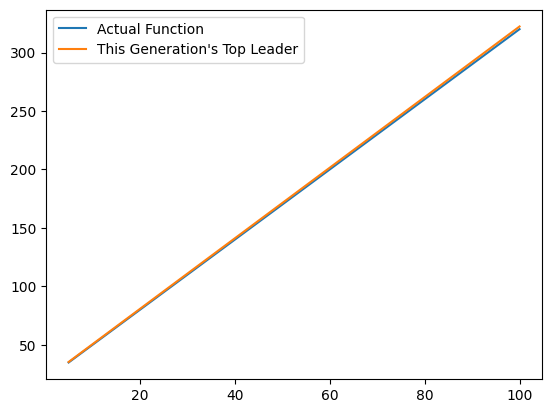

Leaders of the previous generation:(Simplified using Sympy) 
2.9742733565852848*x + 22.59715331602233 Fitness:  0.06964619857331082
3.0192075298096702*x + 20.362026109035329 Fitness:  0.06802365780063703
3.0192075298096702*x + 20.362026109035329 Fitness:  0.06802365780063703


Leaders of the previous generation:(Simplified using Sympy) 
2.9742733565852848*x + 22.59715331602233 Fitness:  0.06964619857331082
3.0192075298096702*x + 20.362026109035329 Fitness:  0.06802365780063703
3.0192075298096702*x + 20.362026109035329 Fitness:  0.06802365780063703


Leaders of the previous generation:(Simplified using Sympy) 
2.9742733565852848*x + 22.59715331602233 Fitness:  0.06964619857331082
3.0192075298096702*x + 20.362026109035329 Fitness:  0.06802365780063703
3.0192075298096702*x + 20.362026109035329 Fitness:  0.06802365780063703


Leaders of the previous generation:(Simplified using Sympy) 
2.9742733565852848*x + 22.59715331602233 Fitness:  0.06964619857331082
3.0192075298096702*x + 20.36202610

In [369]:
import numpy as np
# A simple function
x = np.linspace(5,100,100).reshape(1, 100)
y = 3*x + 20
new_population = Population(x,y,['x'], 3, 1000, 'rmse')
for i in range(20):
    new_population.Evolve()
    if i%10 == 0:
        new_population.PlotLeader()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3244\504112048.py:48: RuntimeWarning: invalid value encountered in scalar power
  return_val = (left_subtree_value) ** right_subtree_value
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3244\1572688157.py:45: RuntimeWarning: overflow encountered in scalar power
  residuals += (tree_value - self.outputs[0][i])**2
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3244\504112048.py:48: RuntimeWarning: overflow encountered in scalar power
  return_val = (left_subtree_value) ** right_subtree_value


Leaders of the previous generation:(Simplified using Sympy) 
-18.41317952520983/x Fitness:  0.004759071467015958
0.0275282092021036/cos(x) Fitness:  0.004725563425352747
0.026703834085602165/cos(x) Fitness:  0.004722541647344586




C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3244\504112048.py:48: RuntimeWarning: divide by zero encountered in scalar power
  return_val = (left_subtree_value) ** right_subtree_value


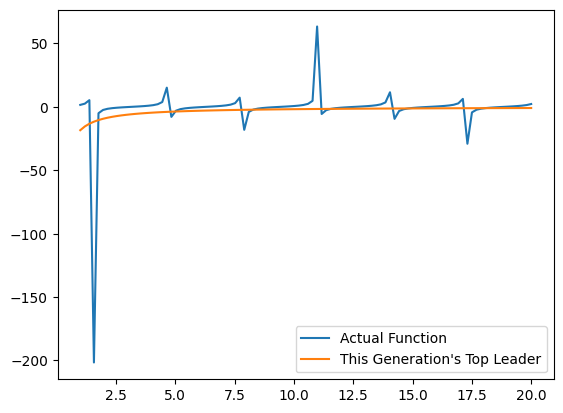

Leaders of the previous generation:(Simplified using Sympy) 
0.9840340319488495/cos(x) Fitness:  0.006876360475232002
1.1811239203175994/cos(x) Fitness:  0.006094111748404678
-18.41317952520983/x Fitness:  0.004759071467015958


Leaders of the previous generation:(Simplified using Sympy) 
0.6099277320076766/cos(x) Fitness:  0.007037989089614811
0.9840340319488495/cos(x) Fitness:  0.006876360475232002
0.5440587281389305/cos(x) Fitness:  0.0068396102607370494


Leaders of the previous generation:(Simplified using Sympy) 
0.6099277320076766/cos(x) Fitness:  0.007037989089614811
0.9840340319488495/cos(x) Fitness:  0.006876360475232002
0.5440587281389305/cos(x) Fitness:  0.0068396102607370494


Leaders of the previous generation:(Simplified using Sympy) 
tan(x) Fitness:  333264196939817.6
tan(x) Fitness:  333264196939817.6
0.67259283988309577/cos(x) Fitness:  0.007173052158870574


Leaders of the previous generation:(Simplified using Sympy) 
tan(x) Fitness:  333264196939817.6
tan(x) Fitness

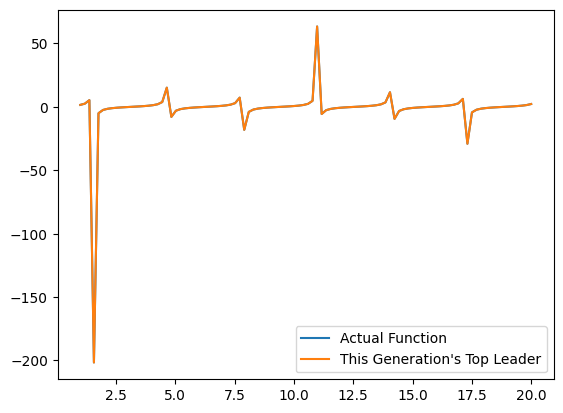

In [372]:
#let's try tan
x = np.linspace(1,20 ,100).reshape(1,100)
y = np.tan(x)
new_population = Population(x, y, ['x'], 2, 1000, 'rmse')
for i in range(11):
    new_population.Evolve()
    if i%10 == 0:
        new_population.PlotLeader()

In [373]:
#note that our symbolic regression hasn't actually guessed tan(x)
#this is the simplification of sympy in work
print(new_population.population[0].print_tree())
new_population.population[0].print_simplified_tree()

(sin(x) / cos(x))


tan(x)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3244\504112048.py:48: RuntimeWarning: invalid value encountered in scalar power
  return_val = (left_subtree_value) ** right_subtree_value
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3244\504112048.py:48: RuntimeWarning: overflow encountered in scalar power
  return_val = (left_subtree_value) ** right_subtree_value
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3244\1572688157.py:45: RuntimeWarning: overflow encountered in scalar power
  residuals += (tree_value - self.outputs[0][i])**2
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3244\504112048.py:48: RuntimeWarning: divide by zero encountered in scalar power
  return_val = (left_subtree_value) ** right_subtree_value


Leaders of the previous generation:(Simplified using Sympy) 
(x - 0.5434777627356695)**0.29588614539037295 Fitness:  0.14714728465026222
cos(4.135981914872171/x) + 2.6024884771146687 Fitness:  0.1405154444698518
3.4000766565842459 Fitness:  0.12385004244184292




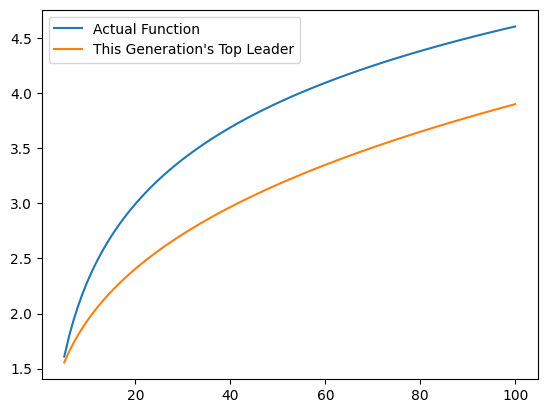

Leaders of the previous generation:(Simplified using Sympy) 
(x - 0.5434777627356695)**0.29588614539037295 Fitness:  0.14714728465026222
cos(4.135981914872171/x) + 2.6024884771146687 Fitness:  0.1405154444698518
3.8273849022598514 Fitness:  0.13732939366401242


Leaders of the previous generation:(Simplified using Sympy) 
(x - 0.5434777627356695)**0.29588614539037295 Fitness:  0.14714728465026222
cos(4.135981914872171/x) + 2.6024884771146687 Fitness:  0.1405154444698518
3.7762431393171765 Fitness:  0.13793848433181036


Leaders of the previous generation:(Simplified using Sympy) 
x**0.29588614539037295 Fitness:  0.14962423542705294
cos(6.767789676191775/x) + 2.6024884771146687 Fitness:  0.14890272503358556
(x - 0.5434777627356695)**0.29588614539037295 Fitness:  0.14714728465026222


Leaders of the previous generation:(Simplified using Sympy) 
0.03394718317380568*x + 1.5814808627930923 Fitness:  0.18902988059843784
1.007929478627652*(0.938507150370623*x - 1)**0.1244501679493337 + 2.1325

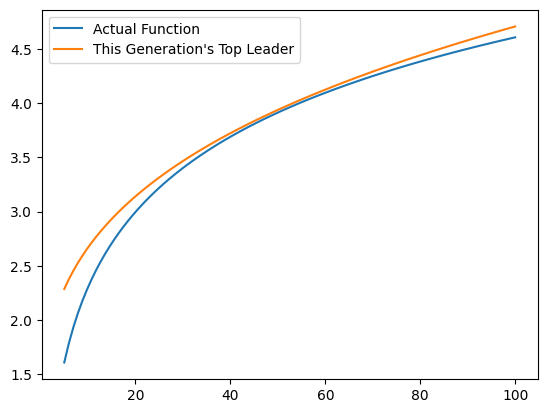

Leaders of the previous generation:(Simplified using Sympy) 
x**0.3036734848341633 + 0.6561555726209325 Fitness:  0.6330126089117091
x**0.3036734848341633 + 0.4535142081768331 Fitness:  0.6253183960273114
x**0.3036734848341633 + 0.7467776999355075 Fitness:  0.4417009284977486


Leaders of the previous generation:(Simplified using Sympy) 
x**0.3036734848341633 + 0.6561555726209325 Fitness:  0.6330126089117091
x**0.3036734848341633 + 0.4535142081768331 Fitness:  0.6253183960273114
x**0.3036734848341633 + 0.7467776999355075 Fitness:  0.4417009284977486


Leaders of the previous generation:(Simplified using Sympy) 
x**0.3036734848341633 + 0.6561555726209325 Fitness:  0.6330126089117091
x**0.3036734848341633 + 0.4535142081768331 Fitness:  0.6253183960273114
x**0.3036734848341633 + 0.7467776999355075 Fitness:  0.4417009284977486


Leaders of the previous generation:(Simplified using Sympy) 
x**0.3036734848341633 + 0.6561555726209325 Fitness:  0.6330126089117091
x**0.3036734848341633 + 0.4535

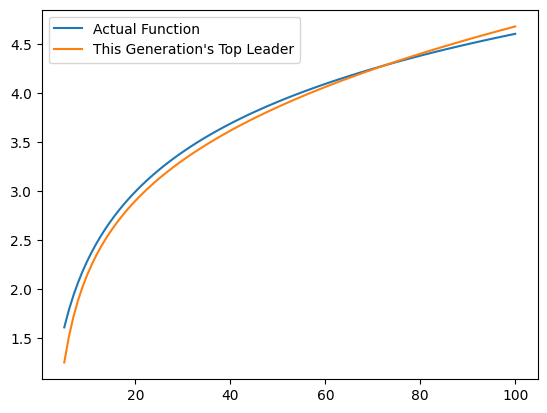

In [375]:
#let's try log
x = np.linspace(5,100,100).reshape(1,100)
y = np.log(x)
new_population = Population(x,y,['x'], 3, 1000, 'rmse')
for i in range(21):
    new_population.Evolve()
    if i%10 == 0:
        new_population.PlotLeader()

In [376]:
new_population.population[0].print_simplified_tree()

x**0.30367348483416329 + 0.6845242237860439 - 5.318316830716457/x

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3244\504112048.py:48: RuntimeWarning: divide by zero encountered in scalar power
  return_val = (left_subtree_value) ** right_subtree_value
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3244\504112048.py:56: RuntimeWarning: invalid value encountered in scalar divide
  return left_subtree_value / right_subtree_value
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3244\1572688157.py:45: RuntimeWarning: overflow encountered in scalar power
  residuals += (tree_value - self.outputs[0][i])**2
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3244\504112048.py:48: RuntimeWarning: overflow encountered in scalar power
  return_val = (left_subtree_value) ** right_subtree_value
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3244\504112048.py:48: RuntimeWarning: invalid value encountered in scalar power
  return_val = (left_subtree_value) ** right_subtree_value
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3244\504112048.py:46: RuntimeWarning: invalid value encoun

Leaders of the previous generation:(Simplified using Sympy) 
46.915362839736386 Fitness:  0.00021185489695217321
(cos(x) + 50.21660349925214)*cos(sin(x)) Fitness:  0.00021072503620072554
32.702151184563561 Fitness:  0.0002079229517714722




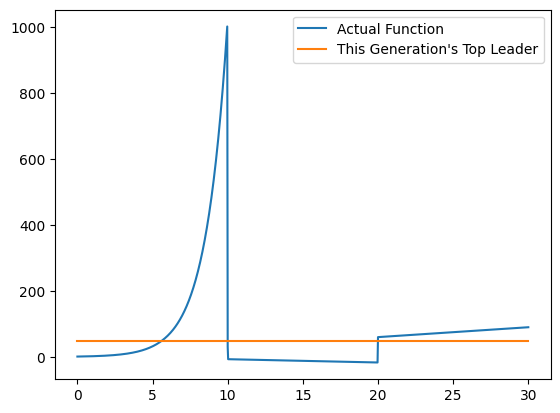

Leaders of the previous generation:(Simplified using Sympy) 
x + 43.920297456279391 Fitness:  0.00021287660801978193
46.915362839736386 Fitness:  0.00021185489695217321
46.645137346487180 Fitness:  0.00021179594545031678


Leaders of the previous generation:(Simplified using Sympy) 
x + 43.920297456279391 Fitness:  0.00021287660801978193
cos(x) + 51.664526153626261 Fitness:  0.00021249961652060223
x + 37.69631554441264 Fitness:  0.00021204544192316062


Leaders of the previous generation:(Simplified using Sympy) 
53.222012266881477 Fitness:  0.00021304404840881286
53.004107305951497 Fitness:  0.0002130090379991062
x + 43.920297456279391 Fitness:  0.00021287660801978193




C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3244\1572688157.py:45: RuntimeWarning: overflow encountered in scalar add
  residuals += (tree_value - self.outputs[0][i])**2


Leaders of the previous generation:(Simplified using Sympy) 
53.222012266881477 Fitness:  0.00021304404840881286
53.025922222164193 Fitness:  0.0002130125628587328
53.004107305951497 Fitness:  0.0002130090379991062


Leaders of the previous generation:(Simplified using Sympy) 
53.222012266881477 Fitness:  0.00021304404840881286
53.025922222164193 Fitness:  0.0002130125628587328
53.004107305951497 Fitness:  0.0002130090379991062


Leaders of the previous generation:(Simplified using Sympy) 
58.131223899461263 Fitness:  0.00021371445626174892
57.001228641145259 Fitness:  0.0002135803823784867
cos(x) + 59.08841362834495 Fitness:  0.00021353211078057314


Leaders of the previous generation:(Simplified using Sympy) 
69.783161733554669 Fitness:  0.00021437441848276957
71.30342392172867 Fitness:  0.0002143622830997872
67.559433466485632 Fitness:  0.0002143511630553353


Leaders of the previous generation:(Simplified using Sympy) 
69.689891838719750 Fitness:  0.00021437442174233095
69.78316173

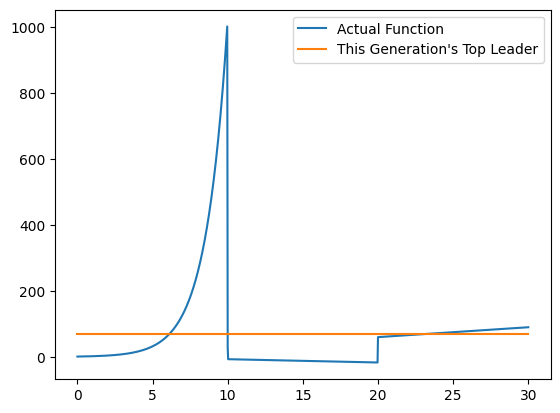

Leaders of the previous generation:(Simplified using Sympy) 
69.689891838719750 Fitness:  0.00021437442174233095
69.689891838719750 Fitness:  0.00021437442174233095
69.689891838719750 Fitness:  0.00021437442174233095


Leaders of the previous generation:(Simplified using Sympy) 
43.920297456279391 - 50.21660349925214*cos(x) Fitness:  0.00021974889007605404
70.47170334590993 - cos(x) Fitness:  0.00021465292714838022
70.564973240744848 - cos(x) Fitness:  0.00021465217286702255


Leaders of the previous generation:(Simplified using Sympy) 
43.920297456279391 - 50.21660349925214*cos(x) Fitness:  0.00021974889007605404
43.920297456279391 - 50.21660349925214*cos(x) Fitness:  0.00021974889007605404
70.47170334590993 - cos(x) Fitness:  0.00021465292714838022


Leaders of the previous generation:(Simplified using Sympy) 
43.920297456279391 - 50.21660349925214*cos(x) Fitness:  0.00021974889007605404
43.920297456279391 - 50.21660349925214*cos(x) Fitness:  0.00021974889007605404
70.47170334590993 

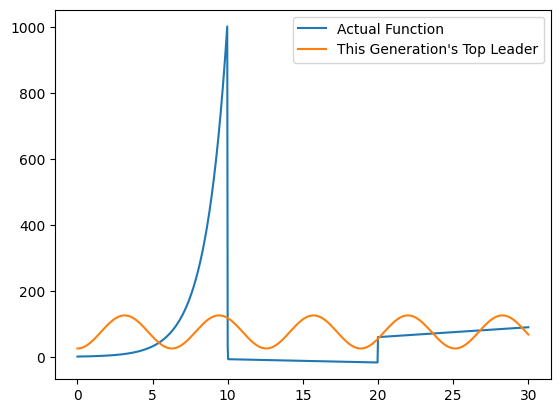

Leaders of the previous generation:(Simplified using Sympy) 
75.714710519582663 - 50.21660349925214*cos(x) Fitness:  0.0002226012377896978
84.959480786473123 - 50.21660349925214*cos(x) Fitness:  0.00022136478942520746
48.596485415437183 - 50.21660349925214*cos(x) Fitness:  0.00022084129139943274


Leaders of the previous generation:(Simplified using Sympy) 
75.714710519582663 - 50.21660349925214*cos(x) Fitness:  0.0002226012377896978
84.959480786473123 - 50.21660349925214*cos(x) Fitness:  0.00022136478942520746
48.596485415437183 - 50.21660349925214*cos(x) Fitness:  0.00022084129139943274




KeyboardInterrupt: 

In [382]:
#import numpy as np
# A simple functio
x = np.linspace(0,30,1000).reshape(1,1000)
y = []
for i in x[0]:
    if i<10:
        y.append(2**i)
    elif i>10 and i<20:
        y.append(3 - i)
    else:
        y.append(3*i)
y = np.array(y).reshape(1, 1000)
new_population = Population(x,y,['x'], 3, 1000, 'rmse')
for i in range(100):
    new_population.Evolve()
    if i%10 == 0:
        new_population.PlotLeader()
    if i==50:
        new_population.criteria = 'R2'

In [340]:
#let's try a multivariable function
x = np.linspace(0,100,100)
y = np.linspace(50,100,100)
z = x**2 + y
new_population = Population(np.stack((x,y)), z, ['x', 'y'], 3, 1000, 'rmse')
for i in range(100):
    new_population.Evolve()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3244\504112048.py:48: RuntimeWarning: divide by zero encountered in scalar power
  return_val = (left_subtree_value) ** right_subtree_value
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3244\504112048.py:48: RuntimeWarning: invalid value encountered in scalar power
  return_val = (left_subtree_value) ** right_subtree_value
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3244\3137821562.py:45: RuntimeWarning: overflow encountered in scalar power
  residuals += (tree_value - self.outputs[i])**2
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3244\504112048.py:48: RuntimeWarning: overflow encountered in scalar power
  return_val = (left_subtree_value) ** right_subtree_value


Leaders of the previous generation:(Simplified using Sympy) 
(x - 7.7441516382827358)*(y - 3.735652347052733) Fitness:  0.000315812352040887
y*(0.9106482644949397*x + 0.1065346670386443) Fitness:  0.00022517782067655947
x*y - cos(y + 0.21106113559905282) Fitness:  0.00016817902921067448


Leaders of the previous generation:(Simplified using Sympy) 
(x - 0.2594003571161353)*(x + 1.066923447011354e-9) Fitness:  0.0015589826800630018
(x - 2.8551322218592033)*(x + 6.85067662491653) Fitness:  0.0009654107867953052
y*(x - 7.7441516382827358) Fitness:  0.000324989629596718


Leaders of the previous generation:(Simplified using Sympy) 
(x - 0.2594003571161353)*(x + 1.066923447011354e-9) Fitness:  0.0015589826800630018
x*(x - 0.2594003571161353) Fitness:  0.0015589826790480556
(x - 2.8551322218592033)*(x + 6.85067662491653) Fitness:  0.0009654107867953052


Leaders of the previous generation:(Simplified using Sympy) 
(x + 1.066923447011354e-9)*(x + 1.1381960885067242) Fitness:  0.00544927226327

In [341]:
#Voila!!
new_population.population[0].print_simplified_tree()

x**2 + y